# 2 MNIST classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

/Users/christinearnoldt/mambaforge/envs/iannwtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Loading the MNIST dataset

In [2]:
(train_ds,val_ds), ds_info = tfds.load('mnist', split =['train', 'test'], as_supervised = True , with_info = True)

2023-11-20 11:26:50.194909: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-20 11:26:50.194930: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-20 11:26:50.194935: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-20 11:26:50.194967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 11:26:50.194982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/christinearnoldt/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }"""

2023-11-20 11:26:53.225961: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


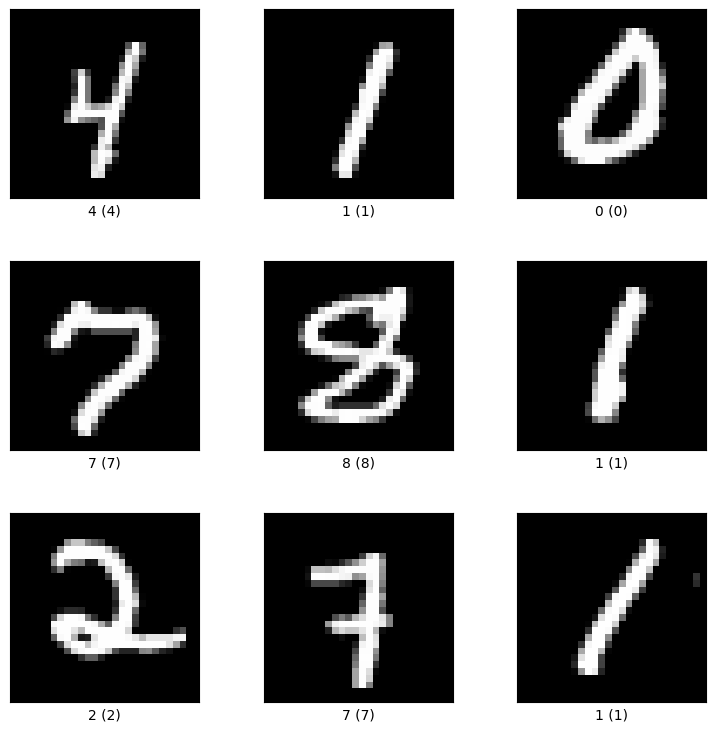

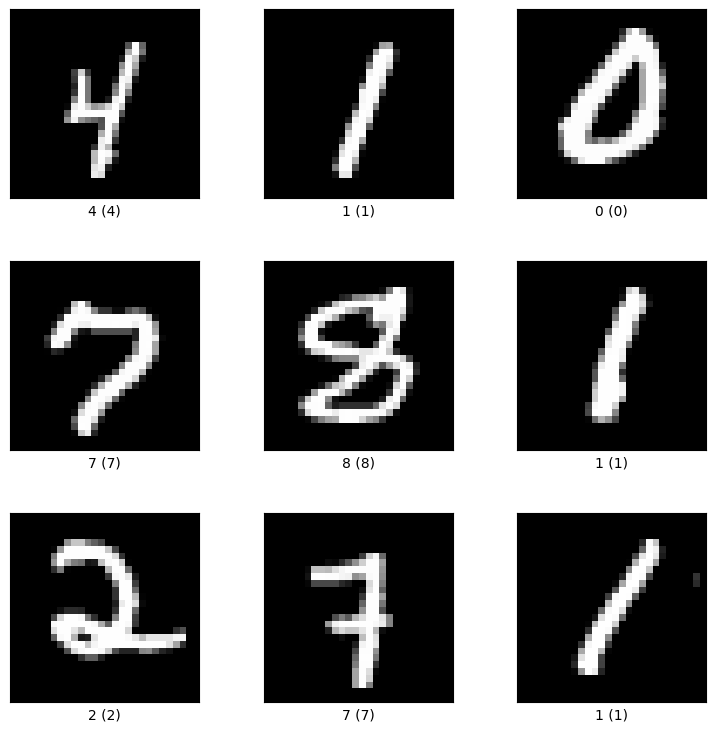

In [4]:
tfds.show_examples(train_ds, ds_info)

### Questions

- How many training/test images are there?
    - There are 60000 training images and 10000 test images.
- What’s the image shape?
    - The shape of each image is (28,28,1).
- What range are pixel values in?
    - The pixels are in uint8 format, meaning they have values in range (0,255)

## 2.2 Setting up the data pipeline

In [5]:
def data_pipeline(ds):
    # flatten image
    ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # cast values to float values between -1 and 1 (normalization)
    ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
    # one hot encode labels
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    return ds

In [6]:
def batched_prefetch(ds, buffersize=2000, batchsize=200, prefetch=4):
    ds = ds.shuffle(buffersize).batch(batchsize)
    ds = ds.prefetch(prefetch)
    return ds

In [7]:
train_ds = data_pipeline(train_ds)
val_ds = data_pipeline(val_ds)
train_ds = batched_prefetch(ds=train_ds)
val_ds = batched_prefetch(ds=val_ds)

## 2.3 Building a deep neural network with TensorFlow

In [8]:
class MLP_Model(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.layers_list = []
        # layer_sizes e.g. [256,256]
        for layer_size in layer_sizes:
            new_layer = tf.keras.layers.Dense(units=layer_size, activation="sigmoid")
            self.layers_list.append(new_layer)
        self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax")
        
    def call(self, x):
        for layer in self.layers_list:
            x = layer(x)
        y = self.output_layer(x)
        return y

## 2.4 Training the network

In [9]:
import numpy as np

In [10]:
def training(model, train_ds, val_ds, epochs=10, loss_function=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.legacy.SGD(), train_accuracy=tf.keras.metrics.SparseCategoricalAccuracy(), val_accuracy=tf.keras.metrics.SparseCategoricalAccuracy()):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        train_loss_batches = []
        val_loss_batches = []
        train_accuracy_batches = []
        val_accuracy_batches = []
        
        for step, (x_batch_train, target_batch_train) in enumerate(train_ds):
            with tf.GradientTape() as tape: # context manager ('with' opens context)
                logits = model(x_batch_train, training=True)
                train_loss = loss_function(y_true=target_batch_train, y_pred=logits)
            grad = tape.gradient(train_loss, model.variables)
            optimizer.apply_gradients(zip(grad, model.variables))
            
            train_accuracy.update_state(tf.argmax(target_batch_train, axis=1), logits)
            
            train_loss_batches.append(train_loss.numpy())
            train_accuracy_batches.append(float(train_accuracy.result()))
            
            # Log every 200 batches.
            if step % 200 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(train_loss))
                )
                print(
                    "Training accuracy (for one batch) at step %d: %.4f"
                    % (step, float(train_accuracy.result()))
                )
                print("Seen so far: %s samples" % ((step + 1) * 200))

        train_losses.append(np.mean(train_loss_batches))
        train_accuracies.append(np.mean(train_accuracy_batches))
         # Reset training metrics at the end of each epoch
        train_accuracy.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, target_batch_val in val_ds:
            val_logits = model(x_batch_val, training=False)
            val_accuracy.update_state(tf.argmax(target_batch_val, axis=1), val_logits)
            val_loss = loss_function(y_true=target_batch_val, y_pred=val_logits)
            val_loss_batches.append(val_loss.numpy())
            val_accuracy_batches.append(float(val_accuracy.result()))
        val_losses.append(np.mean(val_loss_batches))
        val_accuracies.append(np.mean(val_accuracy_batches))
        print("Validation acc: %.4f" % (float(val_accuracy.result()),))
        val_accuracy.reset_states()
    return train_losses, val_losses, train_accuracies, val_accuracies


In [11]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model=MLP_Model(layer_sizes=[256,256,256]),
                                                                        train_ds=train_ds,
                                                                        val_ds=val_ds,
                                                                        epochs=6,
                                                                        loss_function=tf.keras.losses.CategoricalCrossentropy(),
                                                                        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9))


Start of epoch 0
Training loss (for one batch) at step 0: 2.6038
Training accuracy (for one batch) at step 0: 0.0750
Seen so far: 200 samples
Training loss (for one batch) at step 200: 2.2406
Training accuracy (for one batch) at step 200: 0.1472
Seen so far: 40200 samples
Validation acc: 0.4431

Start of epoch 1
Training loss (for one batch) at step 0: 2.1376
Training accuracy (for one batch) at step 0: 0.5050
Seen so far: 200 samples
Training loss (for one batch) at step 200: 1.4558
Training accuracy (for one batch) at step 200: 0.4878
Seen so far: 40200 samples
Validation acc: 0.6656

Start of epoch 2
Training loss (for one batch) at step 0: 1.0651
Training accuracy (for one batch) at step 0: 0.6950
Seen so far: 200 samples
Training loss (for one batch) at step 200: 0.8102
Training accuracy (for one batch) at step 200: 0.7261
Seen so far: 40200 samples
Validation acc: 0.8189

Start of epoch 3
Training loss (for one batch) at step 0: 0.6562
Training accuracy (for one batch) at step 0

## 2.5 Visualization

In [12]:
import matplotlib.pyplot as plt

In [13]:
def visualization (train_losses, train_accuracies, val_losses, val_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    val_losses : numpy . ndarray
    val losses
    val_accuracies : numpy . ndarray
    val accuracies
    """
    #plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(val_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(val_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "validation loss", "train accuracy", "validation accuracy"))
    plt.show()

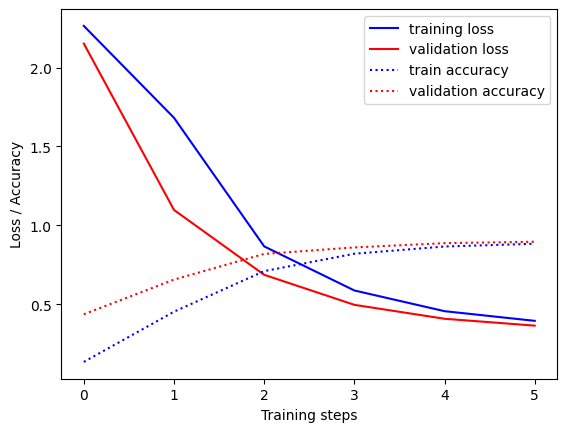

In [14]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

# 3 Adjusting the hyperparameters of your model

## Deviation 1

Interpretation:

## Deviation 2

Interpretation:

## Deviation 3

Interpetation:

## Deviation 4

Interpretation: